# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [1]:
import os
import sys
from random import randint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

from adjustText import adjust_text

from cf_analysis_lib.load_libraries import *
import cf_analysis_lib
from cf_analysis_lib import read_taxonomy, read_metadata

In [2]:
datadir = ".."
sequence_type = "MinION"
taxa = "genus"
df = read_taxonomy(datadir, sequence_type, taxa)
df = df.T
df.head(3)

taxonomy,,,,,,Granulicella,Sulfotelmatobacter,,Hakubella,,...,,Methylacidithermus,Methylacidiphilum (ex Ratnadevi et al. 2023),,Akkermansia,,Brevifollis,Verrucomicrobium,,
1068841_20180306_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5170.349407,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20171218_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20180116_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
metadata = read_metadata(datadir, sequence_type)
metadata.head(3)

,minion,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,...,Sum of meds,Sum of antifungals,Sum of steroid + mabs,DNA_extraction_ conc,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million)
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,1068841_20180306_S,1068841_20180306_S,1068841,3/06/2018,OP,RAH,Chest Clinic 7,47,7,Adult,...,0,0,0,1.070,SAGCFN_22_01754,42.8,CGCTCATT,ATAGAGGC,417,2.8
1128691_20171218_S,1128691_20171218_S,1128691_20171218_S,1128691,12/18/2017,OP,RAH,Chest Clinic 1,47,7,Adult,...,1,0,0,3.400,SAGCFN_22_01743,30.8,ATTACTCG,CAGGACGT,352,4.8
1128691_20180116_S,1128691_20180116_S,1128691_20180116_S,1128691,1/16/2018,OP,RAH,Chest Clinic 4,47,7,Adult,...,1,0,0,0.708,SAGCFN_22_01772,27.4,ATTCAGAA,GGCTCTGA,500,3.8


<Axes: xlabel='Pseudomonas', ylabel='Density'>

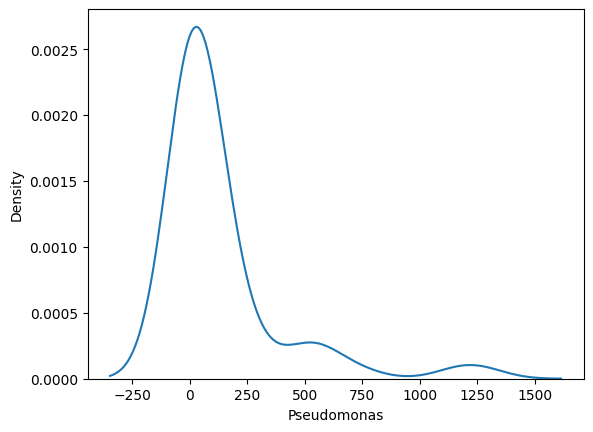

In [4]:
sns.kdeplot(data=df['Pseudomonas'])

In [5]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'Pseudomonas'
mn = np.mean(df[df[genus] > 0][genus])
md = np.median(df[df[genus] > 0][genus])
print(f"The mean for {genus} is {mn} and the median is {md}", file=sys.stderr)

nonzeromean = np.median(df[df[genus] > 0][genus])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['Pseudomonas'], bins=bins, labels=marker_shapes))

The mean for Pseudomonas is 275.4996778648714 and the median is 126.806999746386


In [14]:
df[df['Pseudomonas'] == 0]['Pseudomonas']

1128691_20171218_S    0.0
1128691_20180116_S    0.0
1447437_20171212_S    0.0
1470026_20180502_S    0.0
1565754_20171128_S    0.0
1565754_20180403_S    0.0
1593973_20180427_S    0.0
1845116_20180403_S    0.0
623361_20180123_S     0.0
639354_20171206_S     0.0
650003_20180207_S     0.0
658355_20171204_S     0.0
673895_20180122_S     0.0
673895_20180205_S     0.0
698917_20171207_S     0.0
698917_20180119_S     0.0
715927_20180205_S     0.0
748160_20180321_S     0.0
748160_20180329_S     0.0
748699_20180329_S     0.0
748699_20180410_S     0.0
752797_20170927_S     0.0
753522_20180606_S     0.0
768745_20171123_S     0.0
770590_20170925_S     0.0
788707_20180301_S     0.0
788707_20180313_S     0.0
788707_20181116_S     0.0
802971_20180605_S     0.0
825012_20181120_S     0.0
895293_20180502_S     0.0
983493_20180123_S     0.0
Name: Pseudomonas, dtype: float64

In [6]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]


explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

top_loadings_df.head()

,PC1,PC2
taxonomy,,
Streptococcus,184.887567,-17.607117
Staphylococcus,-115.729428,110.921435
,0.378739,0.084500
,0.080859,0.032492
,0.119254,0.123523


In [7]:
df.columns

Index(['', '', '', '', '', 'Granulicella', 'Sulfotelmatobacter', '',
       'Hakubella', '',
       ...
       '', 'Methylacidithermus',
       'Methylacidiphilum (ex Ratnadevi et al. 2023)', '', 'Akkermansia', '',
       'Brevifollis', 'Verrucomicrobium', '', ''],
      dtype='object', name='taxonomy', length=842)

Loading: Streptococcus (369.77513439563893, -35.21423422454562)
Loading: Staphylococcus (-231.4588567985111, 221.84286966417173)
Loading:  (0.7574777568496166, 0.16899970859931626)
Loading:  (0.1617181167017327, 0.06498413861333105)
Loading:  (0.23850782677825638, 0.2470457637293666)
Loading:  (-0.051407332641012105, -0.3096365280141512)
Loading:  (-0.10059447325638185, -0.28385646894784305)
Loading:  (-5.467111716190719, -26.1089894829982)
Loading:  (-0.11587363507693374, -0.6281796015103048)
Loading:  (-12.856964334583317, -22.11831849929349)
Loading:  (2.5028046138409485, -3.0360240136225283)
Loading:  (9.79091100414883, -7.3504513928907755)
Loading:  (-43.26757047155846, -34.664623202764446)
Loading:  (0.07405081676469188, -0.08684019606028484)
Loading:  (0.1867464755052756, -0.06769797978059669)


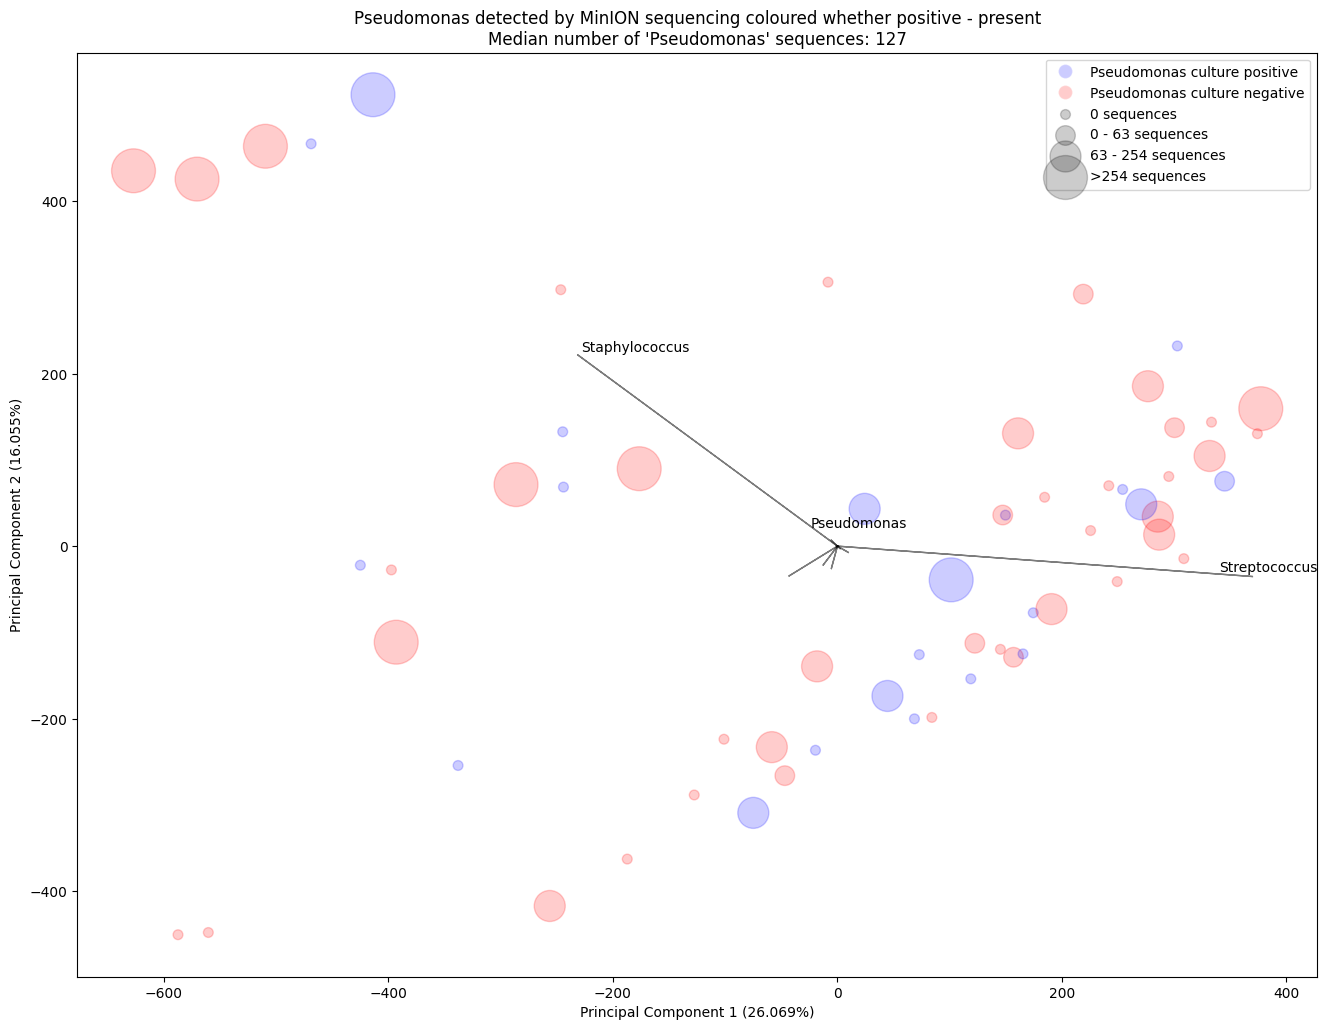

In [8]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))
    print(f"Loading: {top_loadings_df.index[i]} ({xpos}, {ypos})", file=sys.stderr)

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])

# Show the plot
plt.savefig('img/MinION_genus_pseudomonas_present.png')
plt.show()

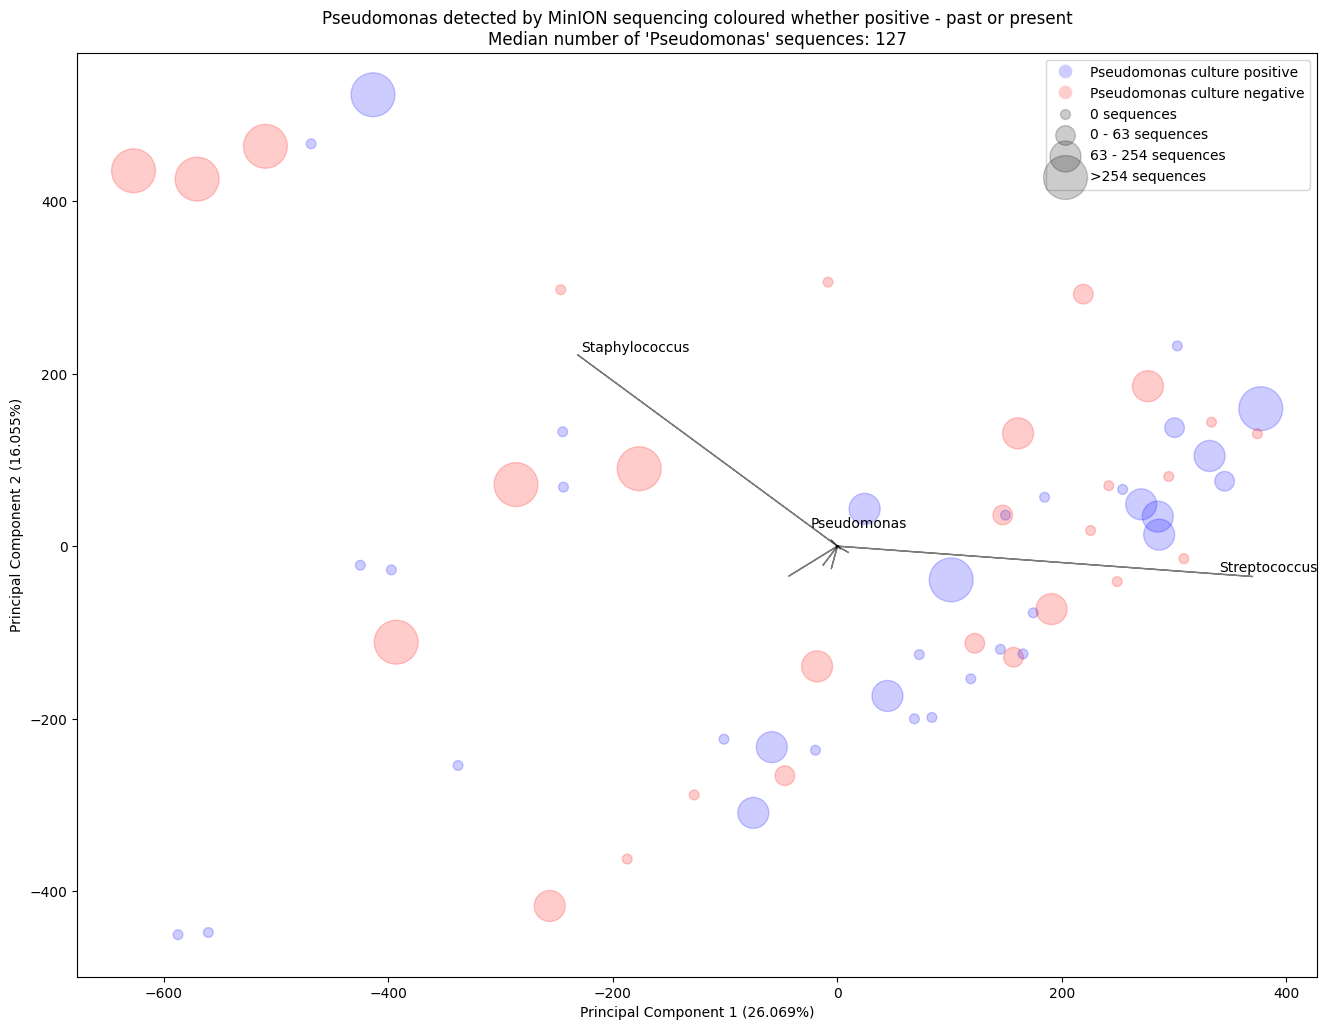

In [9]:
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - past or present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])

plt.savefig('img/MinION_genus_pseudomonas_past_present.png')
# Show the plot
plt.show()

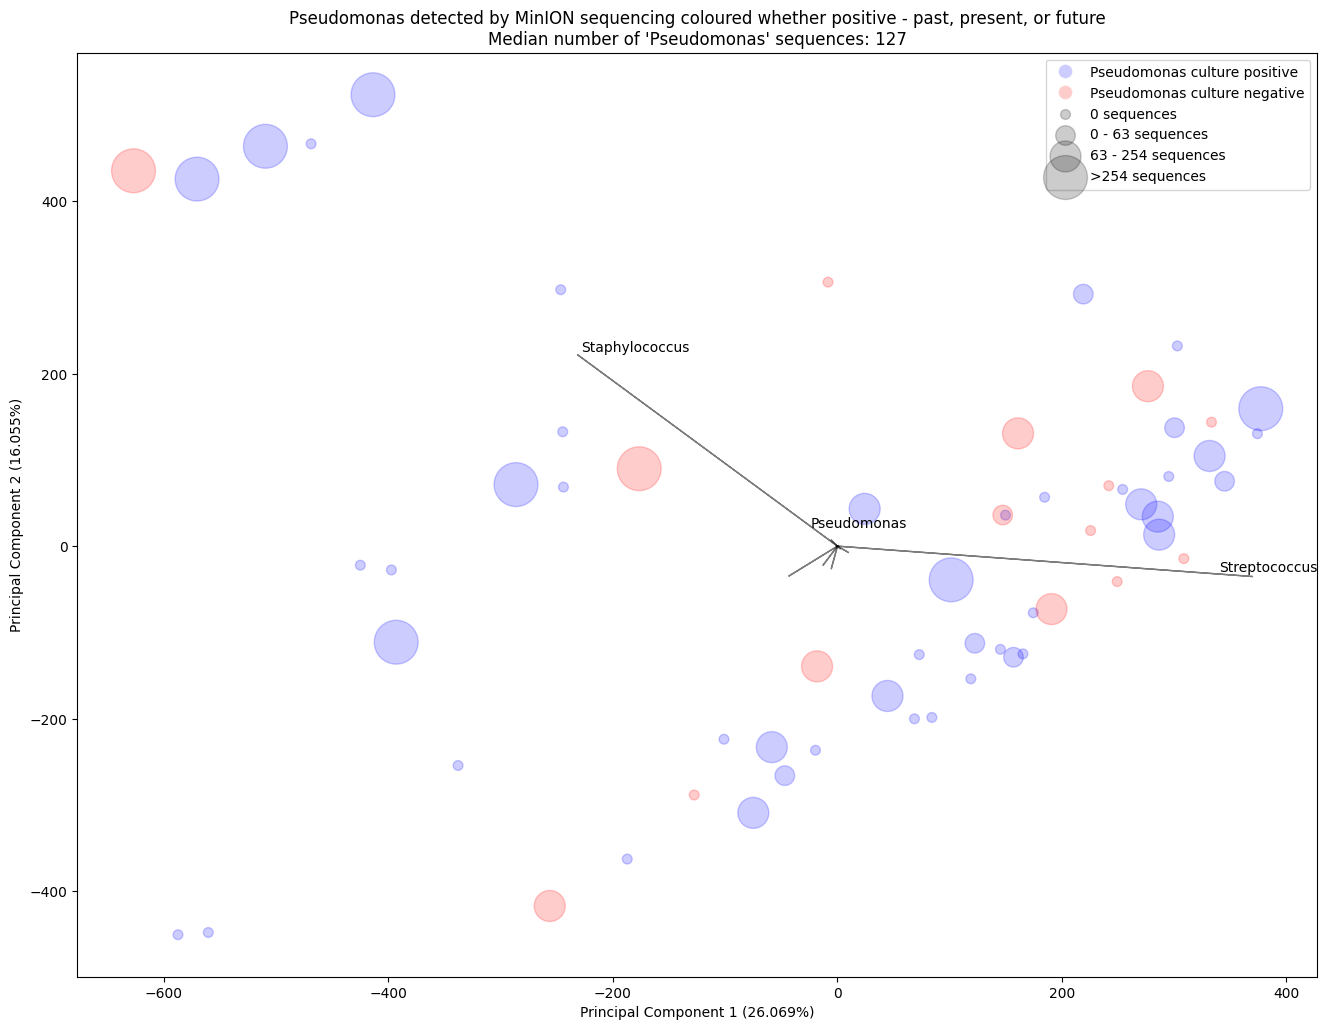

In [10]:
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - past, present, or future' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MinION_genus_pseudomonas_past_present_future.png')
# Show the plot
plt.show()

## Colour by separate current/past/future positivity

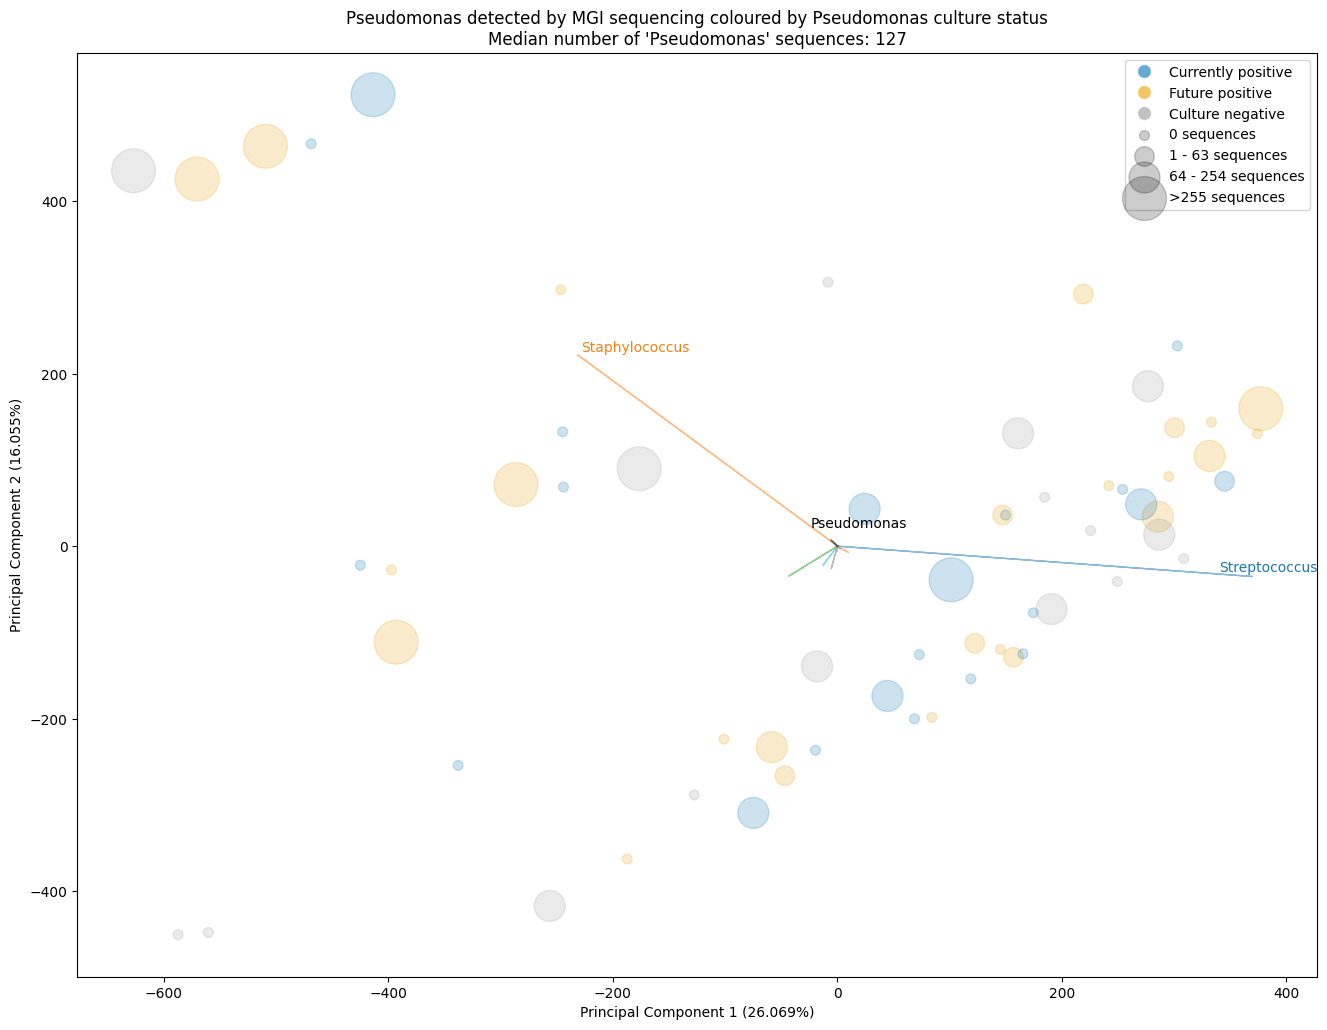

In [15]:
columns_to_check = [
    'CS_Pseudomonas aeruginosa',
    'N12M_Pseudomonas aeruginosa'
]
col_labels = {
    'CS_Pseudomonas aeruginosa' : 'Currently positive',
    'P12M_2_Pseudomonas aeruginosa' : 'Previously positive', 
    'N12M_Pseudomonas aeruginosa' : 'Future positive'
}

# --- Color palette (Okabe–Ito; color-blind friendly) ---
palette = {
    columns_to_check[0]: '#0072B2',  # blue
    columns_to_check[1]: '#E69F00',  # orange
    'None': '#999999',               # grey (no column True)
}

# Vectorized labeling: first True wins (priority is the order in columns_to_check)
vals = metadata[columns_to_check].astype(bool)
labels = np.select(
    [vals[c].values for c in columns_to_check],
    columns_to_check,
    default='None'
)
labels = pd.Series(labels, index=metadata.index)

# Map labels to colors
colours = labels.map(palette)

# === Plot the PCA results ===
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title(
    'Pseudomonas detected by MGI sequencing coloured by Pseudomonas culture status'
    + f"\nMedian number of '{genus}' sequences: {md:.0f}"
)
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# --- Add the loadings (with Pseudomonas highlighted in black) ---
maxloadings = min(20, len(loadings))
plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas and 'Pseudomonas' in top_loadings_df.index:
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

adjust_text(texts)

# --- Legend for color categories ---
legend_handles = []
for key in [columns_to_check[0], columns_to_check[1], 'None']:
    legend_handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w',
            label=col_labels[key] if key != 'None' else 'Culture negative',
            markerfacecolor=palette[key], alpha=0.6, markersize=10
        )
    )

small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]+1:.0f} - {bins[2]:.0f} sequences',
                         alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]+1:.0f} - {bins[3]:.0f} sequences',
                         alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]+1:.0f} sequences',
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=legend_handles + [small_patch, med1_patch, med2_patch, big_patch])

plt.show()


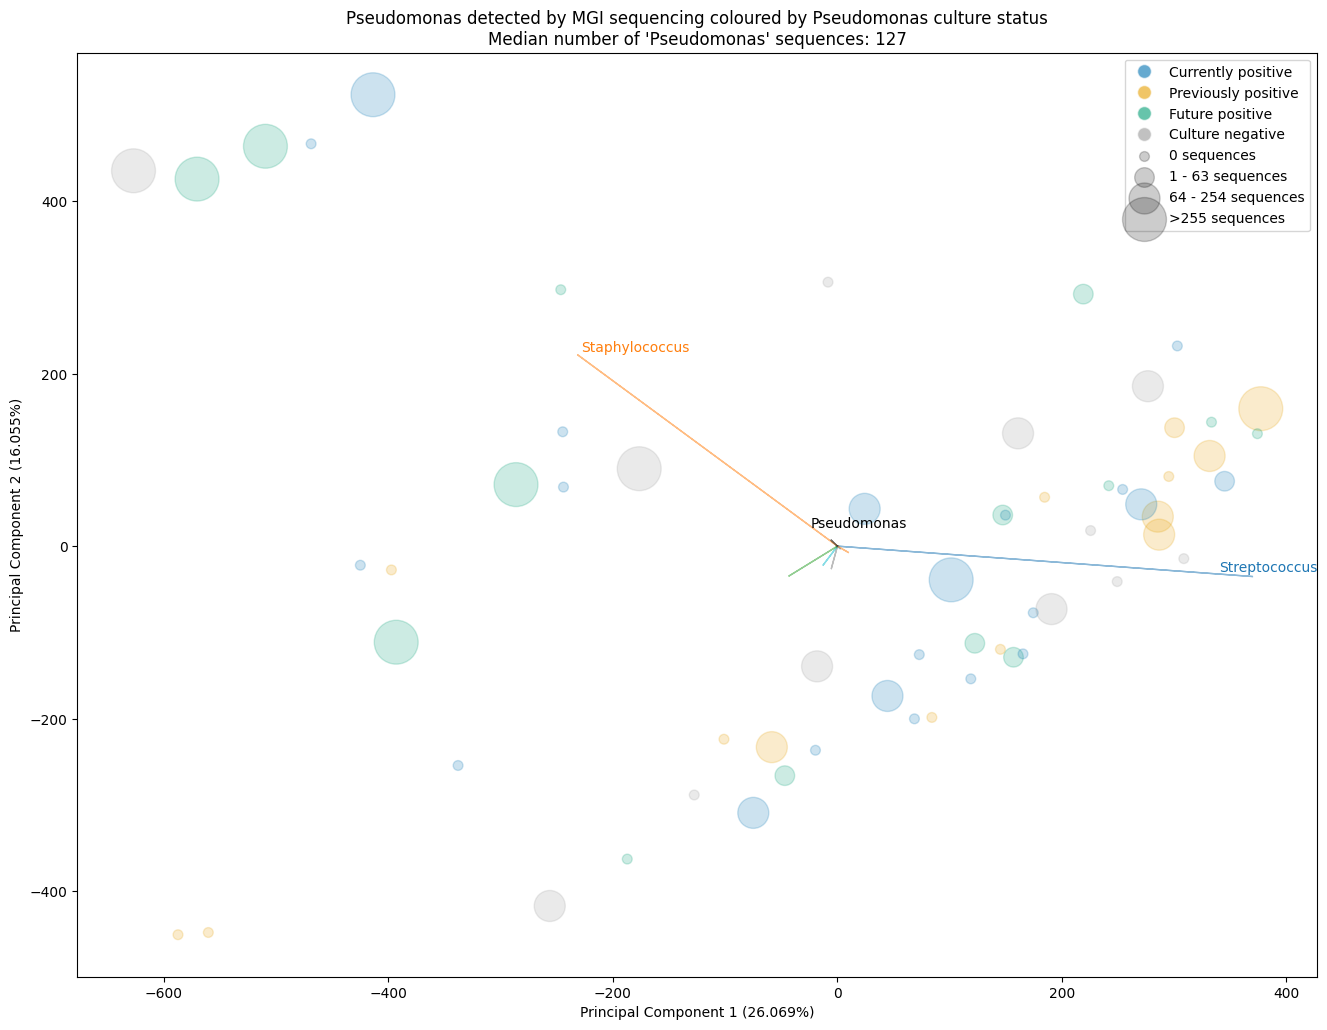

In [16]:
# === Choose your three metadata columns ===
columns_to_check = [
    'CS_Pseudomonas aeruginosa',
    'P12M_2_Pseudomonas aeruginosa', 
    'N12M_Pseudomonas aeruginosa'
]
col_labels = {
    'CS_Pseudomonas aeruginosa' : 'Currently positive',
    'P12M_2_Pseudomonas aeruginosa' : 'Previously positive', 
    'N12M_Pseudomonas aeruginosa' : 'Future positive'
}

# --- Color palette (Okabe–Ito; color-blind friendly) ---
palette = {
    columns_to_check[0]: '#0072B2',  # blue
    columns_to_check[1]: '#E69F00',  # orange
    columns_to_check[2]: '#009E73',  # green
    'None': '#999999',               # grey (no column True)
}

# Vectorized labeling: first True wins (priority is the order in columns_to_check)
vals = metadata[columns_to_check].astype(bool)
labels = np.select(
    [vals[c].values for c in columns_to_check],
    columns_to_check,
    default='None'
)
labels = pd.Series(labels, index=metadata.index)

# Map labels to colors
colours = labels.map(palette)

# === Plot the PCA results ===
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title(
    'Pseudomonas detected by MGI sequencing coloured by Pseudomonas culture status'
    + f"\nMedian number of '{genus}' sequences: {md:.0f}"
)
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# --- Add the loadings (with Pseudomonas highlighted in black) ---
maxloadings = min(15, len(loadings))
plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas and 'Pseudomonas' in top_loadings_df.index:
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

adjust_text(texts)

# --- Legend for color categories ---
legend_handles = []
for key in [columns_to_check[0], columns_to_check[1], columns_to_check[2], 'None']:
    legend_handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w',
            label=col_labels[key] if key != 'None' else 'Culture negative',
            markerfacecolor=palette[key], alpha=0.6, markersize=10
        )
    )


small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]+1:.0f} - {bins[2]:.0f} sequences',
                         alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]+1:.0f} - {bins[3]:.0f} sequences',
                         alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]+1:.0f} sequences',
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=legend_handles + [small_patch, med1_patch, med2_patch, big_patch])

plt.show()
